In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
import PyPlot
using Plots
using BAT
pyplot()

Plots.PyPlotBackend()

In [2]:
function make_2d_hist(samples, ind1, ind2; bins=100)
    
    smpls_flat = flatview(unshaped.(samples.v))
    smpls_w = samples.weight
    
    if length(bins) > 1
        binsx, binsy = bins
    else
        binsx = range(minimum(smpls_flat[ind1,:]), maximum(smpls_flat[ind1,:]), length=bins)
        binsy = range(minimum(smpls_flat[ind2,:]), maximum(smpls_flat[ind2,:]), length=bins)
    end
    
    histogram2D = fit(Histogram, (smpls_flat[ind1,:],smpls_flat[ind2,:]), weights(smpls_w), (binsx, binsy))
    histogram_1Dx = fit(Histogram, smpls_flat[ind1,:], weights(smpls_w), binsx)
    histogram_1Dy = fit(Histogram, smpls_flat[ind2,:], weights(smpls_w), binsy)
    
    histogram2D = normalize(histogram2D, mode=:probability)
    histogram_1Dx = normalize(histogram_1Dx, mode=:probability)
    histogram_1Dy = normalize(histogram_1Dy, mode=:probability)
    
    return (res = histogram2D, x = histogram_1Dx, y = histogram_1Dy)
end

function plot_tree(tree, axes::Array{Int64,1}, plot_ax; kwargs...)
    if tree.terminated_leaf == true
        r = PyPlot.matplotlib.patches.Rectangle([tree.bounds[axes[1],1],tree.bounds[axes[2],1]], tree.bounds[axes[1],2]-tree.bounds[axes[1],1], tree.bounds[axes[2],2]-tree.bounds[axes[2],1], fill=false, linewidth=0.8, color="black", alpha=1,; kwargs...,) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        plot_ax.add_patch(r)
    else
        plot_tree(tree.left_child, axes, plot_ax; kwargs...)
        plot_tree(tree.right_child, axes, plot_ax; kwargs...)
    end
end

plot_tree (generic function with 1 method)

In [3]:
ϕ = 0:1:10
x = exp.(0.35 .* ϕ) .* cos.(ϕ)
y = exp.(0.35.* ϕ) .* sin.(ϕ)

mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i]], [0.05*sqrt(x[i]^2+y[i]^2), 0.05*sqrt(x[i]^2+y[i]^2) ]) for i in 1:length(x)])

iid_distributions = NamedTupleDist(a = mixture_model,)
samples_iid = bat_sample(iid_distributions, IIDSampling(nsamples=2*10^3)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [4]:
# construct partition tree based on the samples_iid 

partition_tree, cost_values  = BAT.partition_space(samples_iid, 40, BAT.KDTreePartitioning());

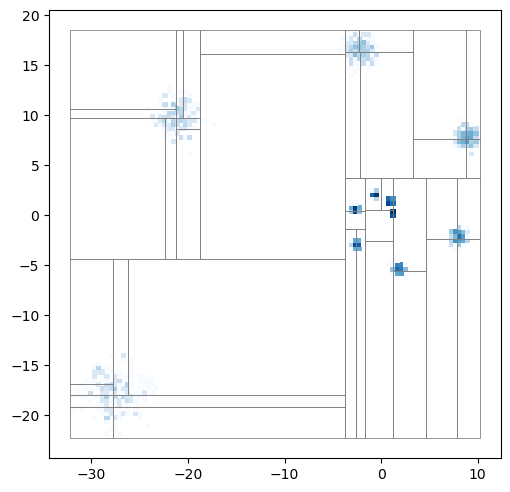

PyObject <matplotlib.patches.Rectangle object at 0x7fb5fd6ef490>

In [5]:
# histogram of samples and tree boudnaries

hist_smpls = make_2d_hist(samples_iid, 1,2, bins=100).res;

fig, ax1 = PyPlot.plt.subplots(figsize=(5.826767123287671, 5.826767123287671),)

ax1.pcolormesh(midpoints(hist_smpls.edges[1]), midpoints(hist_smpls.edges[2]), log.(hist_smpls.weights'), cmap="Blues")

plot_tree(partition_tree, [1,2], ax1, linewidth=0.6, color=:gray, alpha=1)

In [6]:
subspaces_rect_bounds = BAT.get_tree_par_bounds(partition_tree)

subspaces_rect_bounds[1] # columns show minimum/maximum values of each rectangle 

2×2 Matrix{Float64}:
 -32.2498  -27.7542
 -22.2398  -19.2028

In [7]:
# Define new minimum/maximum value

lo_bounds = [-50., -50.]
hi_bounds = [50., 50.]

BAT.extend_tree_bounds!(partition_tree, lo_bounds, hi_bounds);

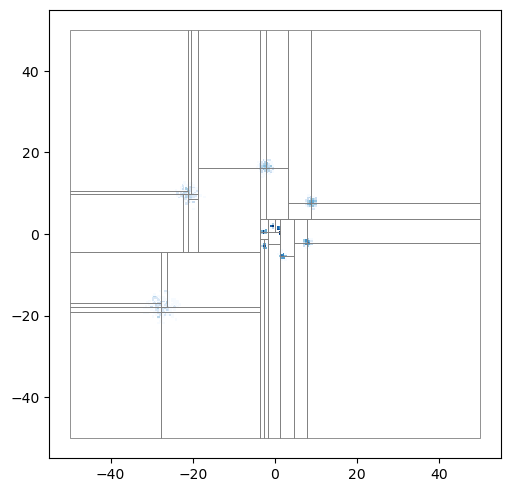

PyObject <matplotlib.patches.Rectangle object at 0x7fb5fd9b63d0>

In [8]:
# plot new mimimum values 

fig, ax1 = PyPlot.plt.subplots(figsize=(5.826767123287671, 5.826767123287671),)

ax1.pcolormesh(midpoints(hist_smpls.edges[1]), midpoints(hist_smpls.edges[2]), log.(hist_smpls.weights'), cmap="Blues")

plot_tree(partition_tree, [1,2], ax1, linewidth=0.6, color=:gray, alpha=1)